#### Import GEE python API and other libraries
-------------------------

In [1]:
import ee
import geemap
from geemap.datasets import DATA
from geemap import cartoee
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#### If running for the first time, authenticate your GEE account. 
#### If you've already done this, comment out the ee.Authenticate() function and run only the ee.Initialize() function.

In [2]:
#ee.Authenticate()
ee.Initialize()

#### Import Santa Rita Experimental Range (SRER) boundary shapefile (uploaded as a GEE asset)
----------------------

In [3]:
srer_shapefile = ee.FeatureCollection("users/cjdevine/SRER_Border")
srer_bounds = srer_shapefile.geometry()
srer_coords = srer_bounds.bounds().getInfo()['coordinates']

# Create function to "unlist" list of bounding coordinates from SRER boundary shapefile
coords_list = []
def flatten_list(coords):
    for element in coords:
        if type(element) == list:
            flatten_list(element)
        else:
            coords_list.append(element)
    return coords_list

flatten_list(srer_coords)

# Extract unique coordinates (should be 4, one for each corner of bounding box)
def unique_list(flat_list):
    unique_coords = []
    for i in flat_list:
        if i not in unique_coords:
            unique_coords.append(i)
    return unique_coords

srer_bb_coords = unique_list(coords_list)

#### Load Landsat8 NDVI product, apply temporal (summers 2020 and 2021) and spatial (SRER boundary shapefile) filters to image collection, and compute mean NDVI for the two time periods.
----------------------

In [8]:
# Load image collections
L8_ndvi_20 = ee.ImageCollection('LANDSAT/LC08/C01/T1_8DAY_NDVI').select('NDVI').filterBounds(srer_bounds).filterDate('2020-07-01','2020-09-30')
L8_ndvi_21 = ee.ImageCollection('LANDSAT/LC08/C01/T1_8DAY_NDVI').select('NDVI').filterBounds(srer_bounds).filterDate('2021-07-01','2021-09-30')

# Calculate mean NDVI for SRER for summers 2020 and 2021
L8_ndvi_mean_20 = L8_ndvi_20.reduce(ee.Reducer.mean())
L8_ndvi_mean_21 = L8_ndvi_21.reduce(ee.Reducer.mean())

#### Plot static maps of mean NDVI using cartoee library (create publication quality figures using images pulled directly from GEE)

In [24]:
# Set NDVI visualization paramters
ndviVis = {'min': 0,'max': 0.55}

# Colormap
gradient = 'RdYlGn'

# Convert SRER boundary shapefile to image (for map overlay)
srer_for_fig = ee.Image().paint(srer_shapefile, color = '#0000000', width = 4)
srerVis = {'palette': 'magenta'}

#### 2020 (01 Jul - 30 Sep)

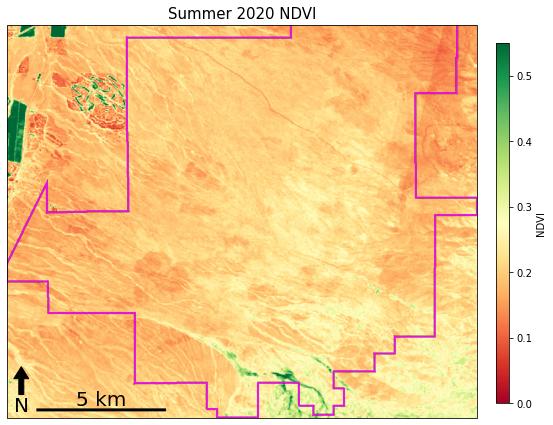

In [25]:
fig = plt.figure(figsize=(9,10))
ax = cartoee.get_map(L8_ndvi_mean_20, cmap = gradient, vis_params = ndviVis, region = srer_bb_coords)
# Add SRER boundary image
cartoee.add_layer(ee_object = srer_for_fig, ax = ax, vis_params = srerVis, region = srer_bb_coords)
# Add colorbar, scale bar, north arrow, and title
cartoee.add_colorbar(ax, cmap = gradient, vis_params = ndviVis, loc = "right", label = "NDVI", orientation = "vertical")
cartoee.add_scale_bar_lite(ax, length = 5, xy = (0.2,0.02), linewidth = 3, color = 'black', unit = 'km')
cartoee.add_north_arrow(ax, text = "N", xy = (0.03, 0.13), text_color = "black", arrow_color = "black", fontsize = 20)
ax.set_title(label = 'Summer 2020 NDVI', fontsize=15)
plt.show()

#### 2021 (01 Jul - 30 Sep)

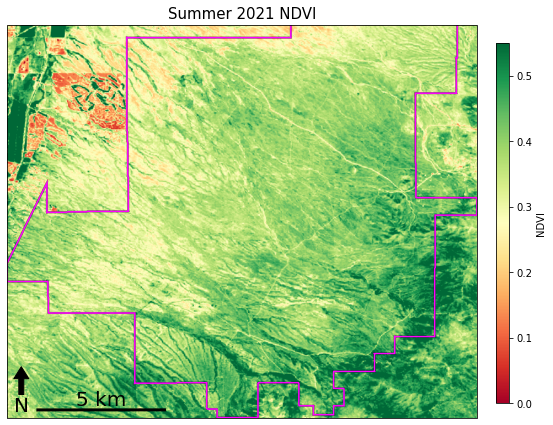

In [26]:
fig = plt.figure(figsize=(9,10))
ax = cartoee.get_map(L8_ndvi_mean_21, cmap = gradient, vis_params = ndviVis, region = srer_bb_coords)
# Add SRER boundary image
cartoee.add_layer(ee_object = srer_for_fig, ax = ax, vis_params = srerVis, region = srer_bb_coords)
# Add colorbar, scale bar, north arrow, and title
cartoee.add_colorbar(ax, cmap = gradient, vis_params = ndviVis, loc = "right", label = "NDVI", orientation = "vertical")
cartoee.add_scale_bar_lite(ax, length = 5, xy = (0.2,0.02), linewidth = 3, color = 'black', unit = 'km')
cartoee.add_north_arrow(ax, text = "N", xy = (0.03, 0.13), text_color = "black", arrow_color = "black", fontsize = 20)
ax.set_title(label = 'Summer 2021 NDVI', fontsize=15)
plt.show()

#### Use geemap library to plot interactive map window

In [6]:
dem = ee.Image(DATA.USGS_SRTMGL1_003)

demVis = {
    'min': 0, 'max': 4000,
    'opacity': 0.75,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}

ndviVis = {
    'min': 0, 'max': 1,
    'palette': ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901','66A000', 
                '529400', '3E8601', '207401', '056201', '004C00', '023B01','012E01', '011D01', '011301']}

left_layer = geemap.ee_tile_layer(L8_ndvi_mean_20, ndviVis, '2020 NDVI (Landsat8)')
right_layer = geemap.ee_tile_layer(L8_ndvi_mean_21, ndviVis, '2021 NDVI (Landsat8)')

Map = geemap.Map()
Map.addLayer(srer_shapefile, {'opacity': 0.75}, 'SRER')
Map.split_map(left_layer, right_layer)
Map.centerObject(srer_shapefile, zoom = 11)
Map

Map(center=[31.841793497382, -110.87079466026435], controls=(ZoomControl(options=['position', 'zoom_in_text', …

#### Load MODIS 16-day vegetation index product (MOD13Q1.006), compute mean NDVI for every image in collection
----------------------

In [11]:
startDate = '2016-01-01'
endDate = '2021-11-01'

modis_ndvi = ee.ImageCollection("MODIS/006/MOD13Q1").filterBounds(srer_bounds).filterDate(startDate,endDate).select('NDVI')

# Create function to generate mean NDVI values from MODIS images cropped to SRER boundary
def MODndviMean(img):
    #Clip image to SRER, apply scale factor
    img_ndvi = img.clip(srer_bounds).multiply(0.0001)
    #Compute mean NDVI from image
    ndvi_mean = img_ndvi.reduceRegion(ee.Reducer.mean(), srer_bounds, 30).get("NDVI")
    #Output image set with mean NDVI
    return img.set('date', img.date().format('YYYY-MM-dd')).set('ndvi_mean',ndvi_mean)

# Map function over image collection
modis_ndvi_mean = modis_ndvi.map(MODndviMean)

# Convert NDVI means to a 2-column list
modis_ndvi_list = modis_ndvi_mean.reduceColumns(ee.Reducer.toList(2), ['date','ndvi_mean']).values().get(0)

# Convert list to pandas data frame, convert date column from string to datetime
modis_ndvi_mean_df = pd.DataFrame(modis_ndvi_list.getInfo(), columns = ['date','ndvi_mean'])
modis_ndvi_mean_df['date'] = pd.to_datetime(modis_ndvi_mean_df['date'])
#modis_ndvi_mean_df = modis_ndvi_mean_df.set_index('date')

#### Plot MODIS NDVI timeseries using matplotlib

Text(0.5, 1.0, 'MODIS MOD13Q1.006 8-Day NDVI\n Santa Rita Experimental Range (SRER) in Tucson, AZ')

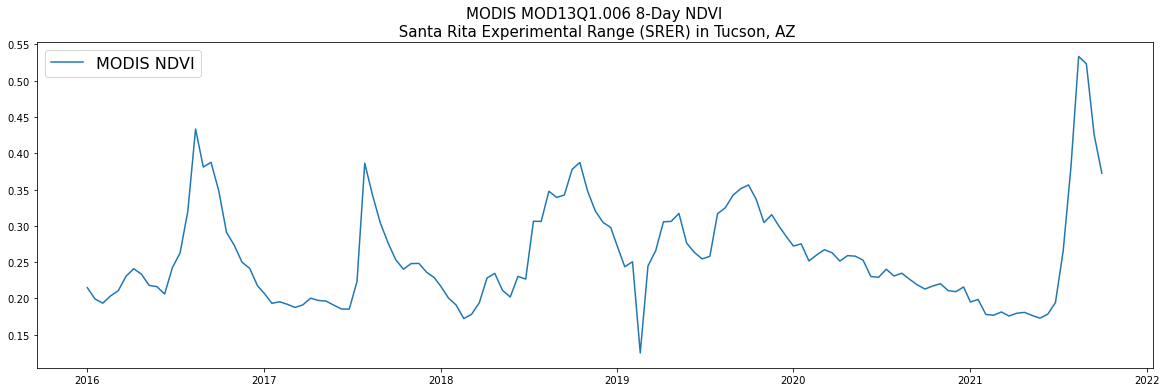

In [12]:
plt.figure(figsize=(20,6))
plt.plot(modis_ndvi_mean_df['date'], modis_ndvi_mean_df['ndvi_mean'], label = 'MODIS NDVI')
plt.legend(loc = 'upper left', fontsize = 16)
plt.title('MODIS MOD13Q1.006 8-Day NDVI\n Santa Rita Experimental Range (SRER) in Tucson, AZ', fontsize = 15)

#### Open locally stored PhenoCam Network data file containing daily GCC from the SRER site
---------------

In [13]:
gcc_path = 'C:/Users/cjdev/Desktop/ECD_Lab_GEE_python/'
srer_gcc = pd.read_csv(gcc_path + 'NEON.D14.SRER.DP1.00033_SH_1000_1dayGCC.txt', delimiter = '\s+')[['date','gcc_90']]
srer_gcc['date'] = pd.to_datetime(srer_gcc['date'])

#### Plot MODIS NDVI and GCC timeseries on figure with two y axes

Text(0, 0.5, 'Phenocam GCC (90th %)')

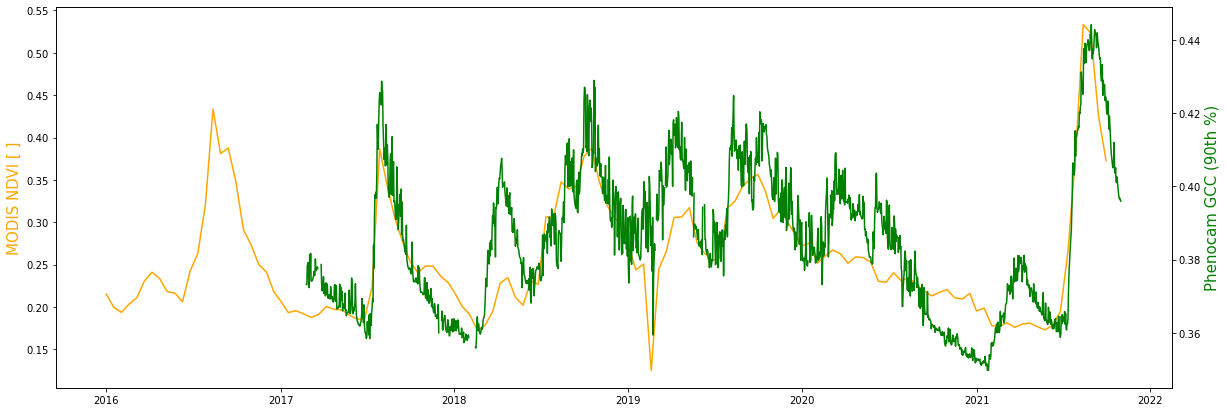

In [18]:
fig, ax = plt.subplots(figsize = (20,7))
ax.plot(modis_ndvi_mean_df['date'], modis_ndvi_mean_df['ndvi_mean'], label = 'MODIS NDVI', color = 'orange')
ax.set_ylabel('MODIS NDVI [ ]', fontsize = 15, color = 'orange')
ax2 = ax.twinx()
ax2.plot(srer_gcc['date'], srer_gcc['gcc_90'], label = 'Phenocam GCC (90th %)', color = 'green')
ax2.set_ylabel('Phenocam GCC (90th %)', fontsize = 15, color = 'green')

#### Merge NDVI and GCC timeseries using dates common between the two datasets, the compute standardized anomalies for each
---------------

In [28]:
# Merge NDVI and GCC data frames
ndvi_gcc_merged = srer_gcc.merge(modis_ndvi_mean_df, on = 'date')
ndvi_gcc_merged = ndvi_gcc_merged[ndvi_gcc_merged['gcc_90'].notna()]
ndvi_gcc_merged = ndvi_gcc_merged[ndvi_gcc_merged['ndvi_mean'].notna()]

# Create function to compute standardized anomalies
def std_anoms(data):
    datamean = np.mean(data)
    datastd = np.std(data)
    std_anoms = (data - datamean) / datastd
    return std_anoms

# Run function
gcc_std_anoms = std_anoms(ndvi_gcc_merged['gcc_90'])
ndvi_std_anoms = std_anoms(ndvi_gcc_merged['ndvi_mean'])

#### Compute R-squared correlation for MODIS NDVI and Phenocam GCC using standardized anomalies
---------------

In [29]:
import numpy.ma as ma

# Create function to compute R^2 correlation
def corr_fun(ndvi, gcc):
    corr_matrix = ma.corrcoef(ma.masked_invalid(gcc), ma.masked_invalid(ndvi))
    corr_xy = corr_matrix[0,1]
    r_squared = corr_xy**2
    return(round(r_squared,2))

# Run function
ndvi_gcc_corr = corr_fun(ndvi_std_anoms, gcc_std_anoms)

#### Plot timeseries and scatterplot for NDVI and GCC standardized anomalies

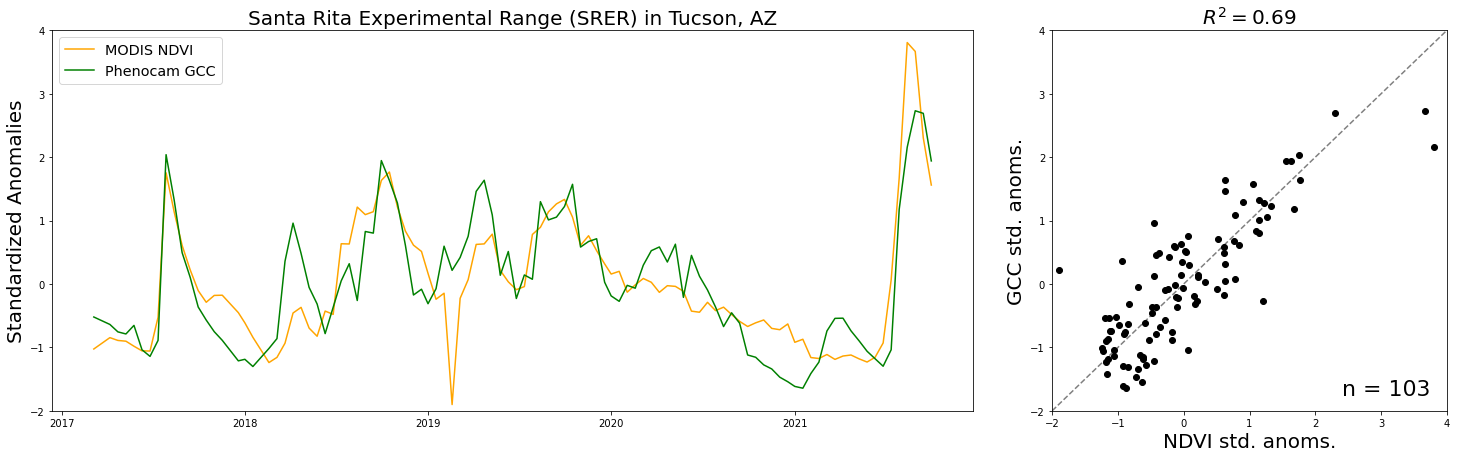

In [34]:
fig, ax = plt.subplots(1,2, figsize = (25,7), gridspec_kw = {'width_ratios': [7,3]})
# Timeseries plot
ax[0].plot(ndvi_gcc_merged['date'], ndvi_std_anoms, label = 'MODIS NDVI', color = 'orange')
ax[0].plot(ndvi_gcc_merged['date'], gcc_std_anoms, label = 'Phenocam GCC', color = 'green')
ax[0].set_ylim([-2,4])
ax[0].set_ylabel('Standardized Anomalies', fontsize = 20)
ax[0].legend(loc = 'upper left', fontsize = 'x-large')
ax[0].set_title('Santa Rita Experimental Range (SRER) in Tucson, AZ', fontsize = 20)
# Scatterplot
ax[1].scatter(ndvi_std_anoms, gcc_std_anoms, color = 'black')
ax[1].plot((0,1),(0,1), transform = ax[1].transAxes, ls = '--', color = 'black', alpha = 0.5)
ax[1].set_ylim([-2,4])
ax[1].set_xlim([-2,4])
ax[1].set_xlabel('NDVI std. anoms.', fontsize = 20)
ax[1].set_ylabel('GCC std. anoms.', fontsize = 20)
ax[1].set_title('$R^2= %.2f$' % ndvi_gcc_corr, fontsize = 20)
ax[1].text(3.75, -1.75, 'n = ' + str(ndvi_gcc_merged.shape[0]), horizontalalignment = 'right', fontsize = 22)
fig.subplots_adjust(wspace = 0.12)